In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import tqdm
import no3inline
import visualize
from IPython.display import clear_output

In [68]:
N = 10

""" HYPERPARAMETERS """
LEARNING_RATE = 0.01
N_ROLLOUTS = 100
N_EPOCHS = 1000
N_ITER = 100
TOP_K_PERCENT = 0.05

In [69]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(1 , 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(N * N, N * N)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear1(x)
        return torch.softmax(x, dim=-1)

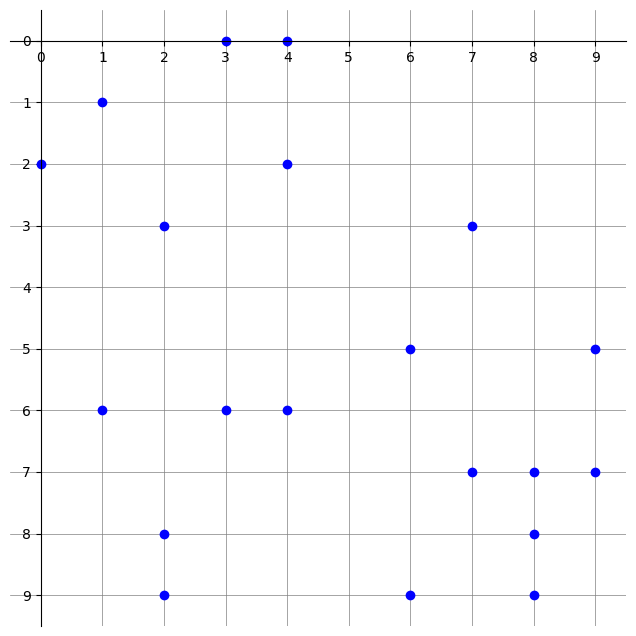

Loss.: 2.4089 Best reward.: 12.8977 Number of lines taken out.: 15:   0%|          | 1/1000 [00:06<1:43:55,  6.24s/it]

2


In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device = }')

model = Generator().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

def calculate_reward(state_list):
    reward=0
    weight=1
    for state in state_list:
        state=state.reshape((N, N))
        reward+=no3inline.calculate_reward(state)*weight
        weight*=0.9
    return reward

def generate_rollout(model, N, device):
    states = [torch.zeros((N * N)).float()]
    
    for _ in range(2 * N):
        next_state_probabilities = model(states[-1].reshape((1, N, N)).to(device)).cpu().detach()[0]
        next_state_probabilities[states[-1] == 1.0] = float('-inf')
        next_state_probabilities = torch.softmax(torch.flatten(next_state_probabilities), dim=-1)
        
        action = torch.multinomial(next_state_probabilities, num_samples=1).item()
        new_state = states[-1].clone()
        new_state[action] = 1
        
        states.append(new_state)
    reward = calculate_reward(states)
    return states, reward

def get_training_data(top_k, N, device):
    return [
        tensor_from_rollout(rollout[0], N).to(device)
        for rollout in top_k
    ]

def tensor_from_rollout(rollout, N):
    stack = torch.stack(rollout).reshape((len(rollout), N, N))
    tensor_list = torch.zeros((2, len(rollout) - 1, N, N))
    tensor_list[0] = stack[:-1]
    tensor_list[1] = stack[1:]
    return tensor_list

def train_epoch(data, model, criterion, optimizer, N):
    epoch_loss = []
    for X, y in data:
        optimizer.zero_grad()
        output = model(X.reshape((2 * N, 1, N, N))).reshape((2 * N, N, N))
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    return np.mean(epoch_loss)

rollouts = []
tq = tqdm.trange(N_EPOCHS)
for _ in tq:
    rollouts.extend([generate_rollout(model, N, device) for _ in range(N_ROLLOUTS)])
    rollouts.sort(key=lambda x: x[1])
    
    top_k = rollouts[:int(N_ROLLOUTS * TOP_K_PERCENT)]
    best_reward = top_k[0][1]
    
    data = get_training_data(top_k, N, device)
    losses = [train_epoch(data, model, criterion, optimizer, N) for _ in range(N_ITER)]
    
    tq.set_description(f'Loss.: {np.mean(losses):.4f} Best reward.: {best_reward:.4f} Number of lines taken out.: {no3inline.calculate_reward(top_k[0][0][-1].reshape((N,N)))}')
    clear_output(wait=True)
    visualize.visualize_grid(top_k[0][0][-1].reshape((N,N)))
    rollouts = rollouts[:N * N_ROLLOUTS * 4]